# Pretraitement

In [1]:
import pandas as pd

In [243]:
df=pd.read_csv('weatherHistory.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [244]:
df.drop(["Summary","Daily Summary"],axis=1, inplace=True)

In [245]:
df['Precip Type'] = df['Precip Type'].apply(lambda x: 0 if x == 'rain' else 1)

In [41]:
df['Formatted Date']

,Formatted Date
0,2006-04-01 00:00:00.000 +0200
1,2006-04-01 01:00:00.000 +0200
2,2006-04-01 02:00:00.000 +0200
3,2006-04-01 03:00:00.000 +0200
4,2006-04-01 04:00:00.000 +0200
...,...
96448,2016-09-09 19:00:00.000 +0200
96449,2016-09-09 20:00:00.000 +0200
96450,2016-09-09 21:00:00.000 +0200
96451,2016-09-09 22:00:00.000 +0200


In [246]:
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)

In [ ]:
df["Formatted Date"]

,Formatted Date
0,2006-03-31 22:00:00+00:00
1,2006-03-31 23:00:00+00:00
2,2006-04-01 00:00:00+00:00
3,2006-04-01 01:00:00+00:00
4,2006-04-01 02:00:00+00:00
...,...
96448,2016-09-09 17:00:00+00:00
96449,2016-09-09 18:00:00+00:00
96450,2016-09-09 19:00:00+00:00
96451,2016-09-09 20:00:00+00:00


In [247]:
df = df.sort_values('Formatted Date')

In [248]:
df['Formatted Date'] = df['Formatted Date'].dt.tz_localize(None)

In [ ]:
df["Formatted Date"]

,Formatted Date
2880,2005-12-31 23:00:00
2881,2006-01-01 00:00:00
2882,2006-01-01 01:00:00
2883,2006-01-01 02:00:00
2884,2006-01-01 03:00:00
...,...
89728,2016-12-31 18:00:00
89729,2016-12-31 19:00:00
89730,2016-12-31 20:00:00
89731,2016-12-31 21:00:00


### Agrégation des données par périodes de la journée

Dans cette section, on transforme la colonne temporelle du jeu de données afin d’obtenir une vision agrégée de la météo selon trois tranches horaires : **matin**, **après-midi** et **nuit**.

1. La colonne `Formatted Date` est convertie en format datetime pour extraire l’heure et la date associées à chaque mesure.  
2. Une fonction `get_period()` classe chaque heure dans une période de la journée.  
3. Pour les heures comprises entre minuit et 6h du matin, la mesure est rattachée au **jour précédent**, afin d’assurer la cohérence temporelle.  
4. Les données sont ensuite agrégées (moyenne) par **date** et **période** sur plusieurs variables météorologiques : température, humidité, vent, pression, etc.  

Ce traitement permet de réduire la granularité horaire du dataset tout en conservant la structure journalière et les variations diurnes de la météo.


In [249]:
import pandas as pd

print(df.columns)

df["Formatted Date"] = pd.to_datetime(df["Formatted Date"])

df["hour"] = df["Formatted Date"].dt.hour

# Créer les périodes (3 tranches de la journée)
def get_period(hour):
    if 6 <= hour < 12:
        return "morning"
    elif 12 <= hour < 18:
        return "afternoon"
    else:
        return "night"

df["period"] = df["hour"].apply(get_period)

df["date"] = df["Formatted Date"].dt.date

mask = df["hour"] < 6
df.loc[mask, "date"] = pd.to_datetime(df.loc[mask, "date"]) - pd.Timedelta(days=1)
df["date"] = pd.to_datetime(df["date"])

result = (
    df.groupby(["date", "period"])
      .agg({
          "Temperature (C)": "mean",
          "Humidity": "mean",
          "Wind Speed (km/h)": "mean",
          "Pressure (millibars)": "mean",
          'Apparent Temperature (C)': 'mean',
          'Wind Bearing (degrees)': 'mean',
          'Visibility (km)': 'mean'
      })
      .reset_index()
)

result = result.sort_values(by=["date", "period"]).reset_index(drop=True)

print(result.head(10))

Index(['Formatted Date', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)'],
      dtype='object')
        date     period  Temperature (C)  Humidity  Wind Speed (km/h)  \
0 2005-12-31      night         1.389683  0.840000          16.983200   
1 2006-01-01  afternoon         6.237963  0.781667          23.481850   
2 2006-01-01    morning         3.087963  0.808333          22.886150   
3 2006-01-01      night         5.353241  0.827500          20.759608   
4 2006-01-02  afternoon         6.402778  0.891667          10.210083   
5 2006-01-02    morning         6.841667  0.750000          22.666117   
6 2006-01-02      night         2.207407  0.921667          15.399650   
7 2006-01-03  afternoon         2.740741  0.895000           7.634083   
8 2006-01-03    morning         2.507407  0.878333           7.231583   
9 2006-01-03      night

In [8]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12055 entries, 0 to 12054
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  12055 non-null  datetime64[ns]
 1   period                12055 non-null  object        
 2   Temperature (C)       12055 non-null  float64       
 3   Humidity              12055 non-null  float64       
 4   Wind Speed (km/h)     12055 non-null  float64       
 5   Pressure (millibars)  12055 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 565.2+ KB


In [156]:
df=result

In [256]:

df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['dayofweek'] = df['date'].dt.dayofweek


### Encodage cyclique des variables temporelles

Les variables temporelles comme le **jour**, le **mois** ou le **jour de la semaine** sont **cycliques** :  
après le dernier jour ou mois, la séquence recommence.  
Par exemple, le jour 31 et le jour 1 sont proches dans le temps, mais leurs valeurs numériques (31 et 1) indiqueraient à tort une grande distance.

Pour modéliser correctement cette cyclicité, on utilise un **encodage trigonométrique** en deux dimensions basé sur les fonctions sinus et cosinus :

$
x_{\text{sin}} = \sin\left(2 \pi \frac{x}{P}\right), \quad
x_{\text{cos}} = \cos\left(2 \pi \frac{x}{P}\right)
$

où :  
- $x$ représente la variable temporelle (ex. le jour du mois, le mois de l’année, etc.),  
- $P$ est la période complète du cycle (ex. $31$ jours, $12$ mois, $7$ jours).

Ainsi :  
- `day_sin` et `day_cos` codent la position du **jour** dans le mois,  
- `month_sin` et `month_cos` codent la position du **mois** dans l’année,  
- `dow_sin` et `dow_cos` codent le **jour de la semaine**.

Cet encodage préserve la **continuité cyclique** des variables temporelles, ce qui facilite leur interprétation par les modèles de machine le


In [257]:
import numpy as np


df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12055 entries, 0 to 12054
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      12055 non-null  datetime64[ns]
 1   period                    12055 non-null  object        
 2   Temperature (C)           12055 non-null  float64       
 3   Humidity                  12055 non-null  float64       
 4   Wind Speed (km/h)         12055 non-null  float64       
 5   Pressure (millibars)      12055 non-null  float64       
 6   Apparent Temperature (C)  12055 non-null  float64       
 7   Wind Bearing (degrees)    12055 non-null  float64       
 8   Visibility (km)           12055 non-null  float64       
 9   day                       12055 non-null  int32         
 10  month                     12055 non-null  int32         
 11  year                      12055 non-null  int32         
 12  dayofweek         

In [258]:
df = df.drop([ 'day', 'month', 'dayofweek'], axis=1)


In [161]:
features = [
    'Temperature (C)',
    'Apparent Temperature (C)',
    'Humidity',
    'Wind Speed (km/h)',
    'Pressure (millibars)',
    'Wind Bearing (degrees)',
    'Visibility (km)',
    'day_sin', 'day_cos',
    'month_sin', 'month_cos'
]

target = 'Temperature (C)'


In [162]:
X=df[features]
y=df[target]

In [130]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12055 entries, 0 to 12054
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Temperature (C)           12055 non-null  float64
 1   Apparent Temperature (C)  12055 non-null  float64
 2   Humidity                  12055 non-null  float64
 3   Wind Speed (km/h)         12055 non-null  float64
 4   Pressure (millibars)      12055 non-null  float64
 5   Wind Bearing (degrees)    12055 non-null  float64
 6   Visibility (km)           12055 non-null  float64
 7   day_sin                   12055 non-null  float64
 8   day_cos                   12055 non-null  float64
 9   month_sin                 12055 non-null  float64
 10  month_cos                 12055 non-null  float64
dtypes: float64(11)
memory usage: 1.0 MB


### Préparation des jeux d’entraînement et de test

Dans cette section, on prépare les données pour l’entraînement du modèle séquentiel.

1. **Découpage temporel** :  
   Le jeu de données est divisé en deux parties selon la chronologie — 80 % pour l’entraînement et 20 % pour le test — afin d’éviter toute fuite d’information future dans le passé.

2. **Séparation features / target** :  
   Les variables explicatives (`features`) et la variable cible (`target`) sont extraites pour chaque sous-ensemble.

3. **Normalisation Min-Max** :  
   Les données sont mises à l’échelle dans l’intervalle \([0,1]\) à l’aide du `MinMaxScaler`.  
   Cette étape améliore la stabilité numérique du modèle et accélère la convergence pendant l’apprentissage :

$
x' = \frac{x - x_{\min}}{x_{\max} - x_{\min}}
$


4. **Création des séquences temporelles** :  
   La fonction `create_sequences()` transforme les séries normalisées en **fenêtres glissantes** de longueur `window`.  
   Chaque séquence contient les observations des \( w \) derniers pas de temps et la cible correspond au pas suivant.

5. **Résultat final** :  
   Les tableaux `X_train_seq` et `y_train_seq` représentent respectivement les entrées et sorties d’entraînement, tandis que `X_test_seq` et `y_test_seq` servent pour l’évaluation.  
   Ces structures 3D sont adaptées aux modèles de type RNN ou LSTM.


In [53]:
split = int(0.8 * len(df))
train = df[:split]
test = df[split:]

X_train = train[features].values
y_train = train[[target]].values

X_test = test[features].values
y_test = test[[target]].values


In [55]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)


In [56]:
def create_sequences(X, y, window):
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X[i-window:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)


In [120]:
window = 42
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, window)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, window)

print("Train:", X_train_seq.shape, y_train_seq.shape)
print("Test :", X_test_seq.shape, y_test_seq.shape)


Train: (9602, 42, 11) (9602, 1)
Test : (2369, 42, 11) (2369, 1)


In [58]:
import joblib
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')


['scaler_y.pkl']

In [59]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt


In [60]:
class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [121]:
batch_size = 64

train_data = WeatherDataset(X_train_seq, y_train_seq)
test_data = WeatherDataset(X_test_seq, y_test_seq)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


#On commence par un modèle LSTM

In [62]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out


In [63]:
input_size = X_train_seq.shape[2]
hidden_size = 64
num_layers = 2
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


LSTMModel(
  (lstm): LSTM(11, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [64]:
import torch
import torch.nn.functional as F
import torch.nn as nn

class ValueDeltaLoss(nn.Module):
    def __init__(self, alpha,
                 y_mean, y_std,          # scaler_y params (pour T)
                 x_temp_mean, x_temp_std # scaler_X params pour la colonne Temp dans X
                 ):
        super().__init__()
        self.alpha = alpha
        # on enregistre comme buffers pour rester sur le bon device
        self.register_buffer('y_mean', torch.tensor([y_mean], dtype=torch.float32))
        self.register_buffer('y_std',  torch.tensor([y_std],  dtype=torch.float32))
        self.register_buffer('x_mean', torch.tensor([x_temp_mean], dtype=torch.float32))
        self.register_buffer('x_std',  torch.tensor([x_temp_std],  dtype=torch.float32))

    def forward(self, y_hat, y_true, x_seq, temp_col=0):
        # MSE sur la valeur (espace standardisé y)
        val_loss = F.mse_loss(y_hat, y_true)

        # Remise en échelle PHYSIQUE
        y_hat_phys  = y_hat * self.y_std  + self.y_mean     # (B,1)
        y_true_phys = y_true* self.y_std  + self.y_mean
        last_x      = x_seq[:, -1:, temp_col]               # (B,1)
        last_phys   = last_x * self.x_std + self.x_mean

        # Deltas en unités physiques
        delta_hat  = y_hat_phys  - last_phys
        delta_true = y_true_phys - last_phys

        delta_loss = F.mse_loss(delta_hat, delta_true)

        return self.alpha * val_loss + (1.0 - self.alpha) * delta_loss


In [65]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [66]:
epochs = 20
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{epochs} — Loss: {train_losses[-1]:.4f}")


Epoch 1/20 — Loss: 0.0343
Epoch 2/20 — Loss: 0.0059
Epoch 3/20 — Loss: 0.0055
Epoch 4/20 — Loss: 0.0051
Epoch 5/20 — Loss: 0.0050
Epoch 6/20 — Loss: 0.0048
Epoch 7/20 — Loss: 0.0045
Epoch 8/20 — Loss: 0.0043
Epoch 9/20 — Loss: 0.0038
Epoch 10/20 — Loss: 0.0031
Epoch 11/20 — Loss: 0.0024
Epoch 12/20 — Loss: 0.0021
Epoch 13/20 — Loss: 0.0020
Epoch 14/20 — Loss: 0.0019
Epoch 15/20 — Loss: 0.0019
Epoch 16/20 — Loss: 0.0018
Epoch 17/20 — Loss: 0.0018
Epoch 18/20 — Loss: 0.0018
Epoch 19/20 — Loss: 0.0017
Epoch 20/20 — Loss: 0.0017


In [67]:
model.eval()
preds, reals = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch)
        preds.append(y_pred.cpu().numpy())
        reals.append(y_batch.numpy())

preds = np.concatenate(preds)
reals = np.concatenate(reals)


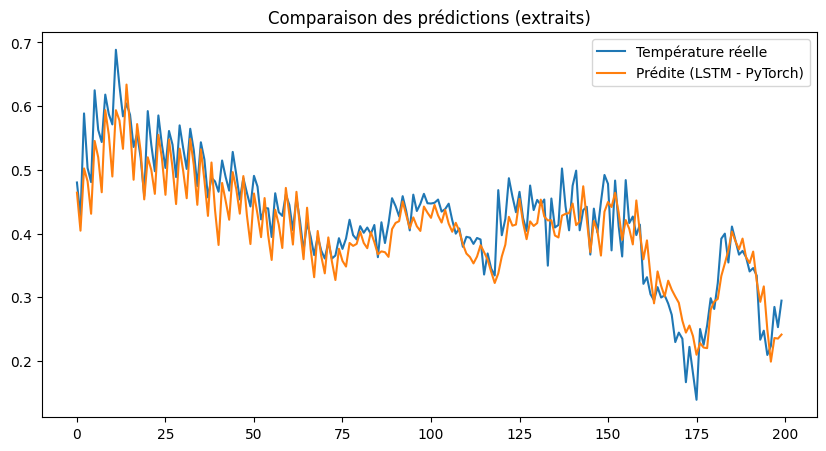

In [68]:
plt.figure(figsize=(10,5))
plt.plot(reals[:200], label='Température réelle')
plt.plot(preds[:200], label='Prédite (LSTM - PyTorch)')
plt.legend()
plt.title('Comparaison des prédictions (extraits)')
plt.show()


In [69]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(reals, preds)
mae = mean_absolute_error(reals, preds)
rmse = np.sqrt(mse)

print(f"MSE  : {mse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")


MSE  : 0.0019
MAE  : 0.0355
RMSE : 0.0438


In [70]:
from sklearn.metrics import r2_score

r2 = r2_score(reals, preds)
print(f"R² : {r2:.4f}")


R² : 0.9245


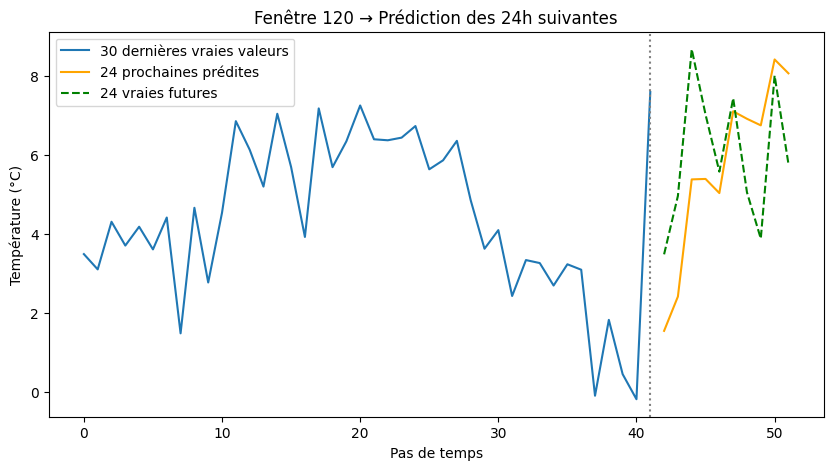

In [72]:
predict_and_plot(
    i=120 ,
    model=model,
    X_seq=X_test_seq,
    y_seq=y_test_seq,
    scaler_y=scaler_y,
    steps=10,
    device=device
)


In [73]:
y_pred_naive = y_test_seq[:-1]
y_true_naive = y_test_seq[1:]
r2_naive = r2_score(y_true_naive, y_pred_naive)
print(r2_naive)

0.6863982508384853


In [74]:
delta_true = reals[1:] - reals[:-1]
delta_pred = preds[1:] - preds[:-1]
r2_change = r2_score(delta_true, delta_pred)
print(r2_change)

0.7257876396179199


#Passant à la prédiction de la variation de température

In [71]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def predict_and_plot(i, model, X_seq, y_seq, scaler_y, steps=24, device='cpu'):

    X_start = X_seq[i:i+1, :, :]

    model.eval()
    preds = []
    x = torch.tensor(X_start, dtype=torch.float32).to(device)
    with torch.no_grad():
        for _ in range(steps):
            y_pred = model(x)
            preds.append(y_pred.cpu().numpy())
            y_pred_feature = y_pred.unsqueeze(-1).repeat(1, 1, x.shape[2])
            x = torch.cat((x[:, 1:, :], y_pred_feature), dim=1)
    preds = np.array(preds).reshape(-1, 1)
    preds = scaler_y.inverse_transform(preds)

    real_past = X_start[0, :, 0]
    real_past = scaler_y.inverse_transform(real_past.reshape(-1, 1))
    real_future = scaler_y.inverse_transform(y_seq[i:i+steps])
    plt.figure(figsize=(10,5))
    plt.plot(range(len(real_past)), real_past, label='30 dernières vraies valeurs')
    plt.plot(range(len(real_past), len(real_past)+len(preds)), preds, label='24 prochaines prédites', color='orange')
    plt.plot(range(len(real_past), len(real_past)+len(real_future)), real_future, label='24 vraies futures', color='green', linestyle='--')
    plt.axvline(x=len(real_past)-1, color='gray', linestyle=':')
    plt.title(f"Fenêtre {i} → Prédiction des 24h suivantes")
    plt.xlabel("Pas de temps")
    plt.ylabel("Température (°C)")
    plt.legend()
    plt.show()


In [75]:
import torch
import torch.nn.functional as F
import torch.nn as nn

class ValueDeltaLoss_MinMax(nn.Module):
    def __init__(self, alpha, y_min, y_max, x_temp_min, x_temp_max):
        super().__init__()
        self.alpha = alpha
        self.register_buffer('y_min', torch.tensor([y_min], dtype=torch.float32))
        self.register_buffer('y_max', torch.tensor([y_max], dtype=torch.float32))
        self.register_buffer('x_min', torch.tensor([x_temp_min], dtype=torch.float32))
        self.register_buffer('x_max', torch.tensor([x_temp_max], dtype=torch.float32))

    def forward(self, y_hat, y_true, x_seq, temp_col=0):

        device = y_hat.device
        y_min = self.y_min.to(device)
        y_max = self.y_max.to(device)
        x_min = self.x_min.to(device)
        x_max = self.x_max.to(device)
        x_seq = x_seq.to(device)
        y_true = y_true.to(device)
        y_hat = y_hat.to(device)

        val_loss = F.mse_loss(y_hat, y_true)

        y_hat_phys  = y_hat * (y_max - y_min) + y_min
        y_true_phys = y_true * (y_max - y_min) + y_min
        last_x      = x_seq[:, -1:, temp_col]
        last_phys   = last_x * (x_max - x_min) + x_min

        delta_hat  = y_hat_phys  - last_phys
        delta_true = y_true_phys - last_phys
        delta_loss = F.mse_loss(delta_hat, delta_true)

        return self.alpha * val_loss + (1 - self.alpha) * delta_loss



In [76]:
loss_fn = ValueDeltaLoss_MinMax(
    alpha=0.4,
    y_min=scaler_y.data_min_[0],
    y_max=scaler_y.data_max_[0],
    x_temp_min=scaler_X.data_min_[0],
    x_temp_max=scaler_X.data_max_[0]
)


In [85]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def train_model(model, train_loader, test_loader, loss_fn, optimizer, epochs=20, device='cpu'):

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)

            loss = loss_fn(y_pred, y_batch, X_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in test_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                y_pred_val = model(X_val)
                loss_val = loss_fn(y_pred_val, y_val, X_val)
                val_loss += loss_val.item()

        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(test_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        if (epoch+1) % 10 == 0:
          print(f"Epoch {epoch+1}/{epochs} | "
                f"Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Courbe de perte (ValueDeltaLoss)')
    plt.legend()
    plt.show()

    return model, train_losses, val_losses


In [123]:
input_size = X_train_seq.shape[2]
hidden_size = 500
num_layers = 3
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


LSTMModel(
  (lstm): LSTM(11, 500, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=500, out_features=1, bias=True)
)

Epoch 10/100 | Train Loss: 3.739795 | Val Loss: 3.364666
Epoch 20/100 | Train Loss: 3.007273 | Val Loss: 2.825186
Epoch 30/100 | Train Loss: 2.673045 | Val Loss: 3.762937
Epoch 40/100 | Train Loss: 2.596250 | Val Loss: 2.142820
Epoch 50/100 | Train Loss: 2.494929 | Val Loss: 3.431804
Epoch 60/100 | Train Loss: 2.453111 | Val Loss: 2.384358
Epoch 70/100 | Train Loss: 2.312119 | Val Loss: 2.098435
Epoch 80/100 | Train Loss: 2.250189 | Val Loss: 2.066207
Epoch 90/100 | Train Loss: 2.159309 | Val Loss: 2.688838
Epoch 100/100 | Train Loss: 2.154122 | Val Loss: 2.044043


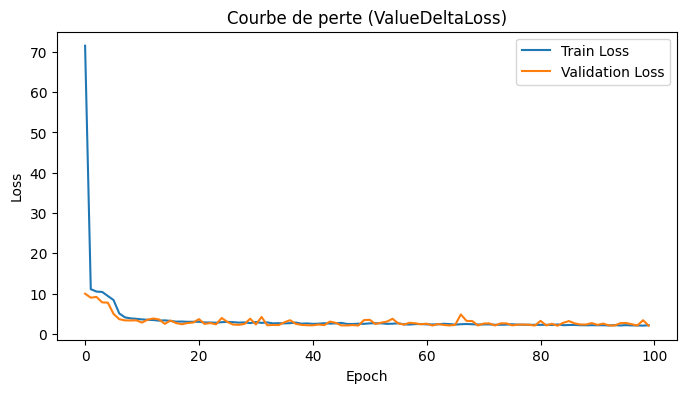

In [94]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=100,
    device=device
)



In [95]:
import numpy as np
import torch
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, scaler_y, device='cpu'):
    model.eval()
    preds, reals = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            preds.append(y_pred.cpu().numpy())
            reals.append(y_batch.cpu().numpy())

    preds = np.concatenate(preds).reshape(-1, 1)
    reals = np.concatenate(reals).reshape(-1, 1)

    preds_inv = scaler_y.inverse_transform(preds)
    reals_inv = scaler_y.inverse_transform(reals)

    mae = mean_absolute_error(reals_inv, preds_inv)
    rmse = np.sqrt(mean_squared_error(reals_inv, preds_inv))
    r2 = r2_score(reals_inv, preds_inv)

    delta_true = reals_inv[1:] - reals_inv[:-1]
    delta_pred = preds_inv[1:] - preds_inv[:-1]
    r2_delta = r2_score(delta_true, delta_pred)

    print("🔹 Évaluation du modèle")
    print(f"R² global       : {r2:.4f}")
    print(f"R² sur ΔT       : {r2_delta:.4f}")
    print(f"MAE             : {mae:.4f} °C")
    print(f"RMSE            : {rmse:.4f} °C")

    plt.figure(figsize=(10,5))
    plt.plot(reals_inv[:200], label='Réel (°C)')
    plt.plot(preds_inv[:200], label='Prédit (°C)')
    plt.title("Comparaison des 200 premières prédictions")
    plt.xlabel("Pas de temps")
    plt.ylabel("Température (°C)")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(reals_inv[:200] - preds_inv[:200])
    plt.title("Erreur de prédiction sur les 200 premiers pas")
    plt.xlabel("Pas de temps")
    plt.ylabel("Erreur (°C)")
    plt.show()

    return preds_inv, reals_inv, (r2, r2_delta, mae, rmse)


🔹 Évaluation du modèle
R² global       : 0.9592
R² sur ΔT       : 0.7671
MAE             : 1.3080 °C
RMSE            : 1.8683 °C


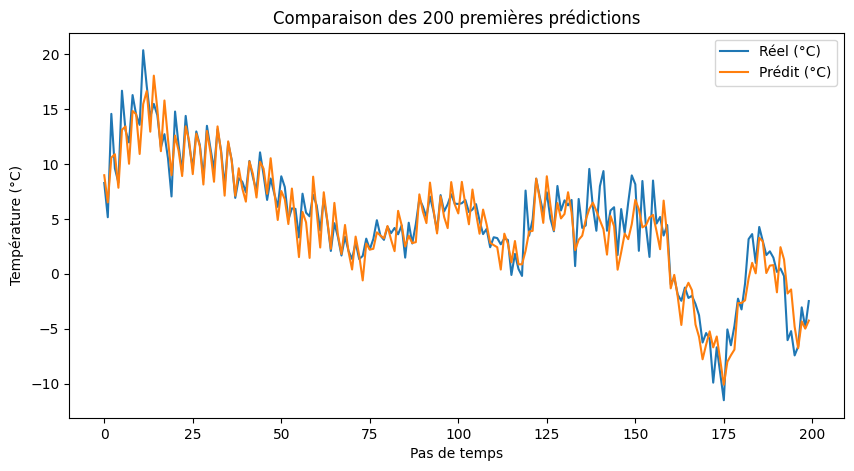

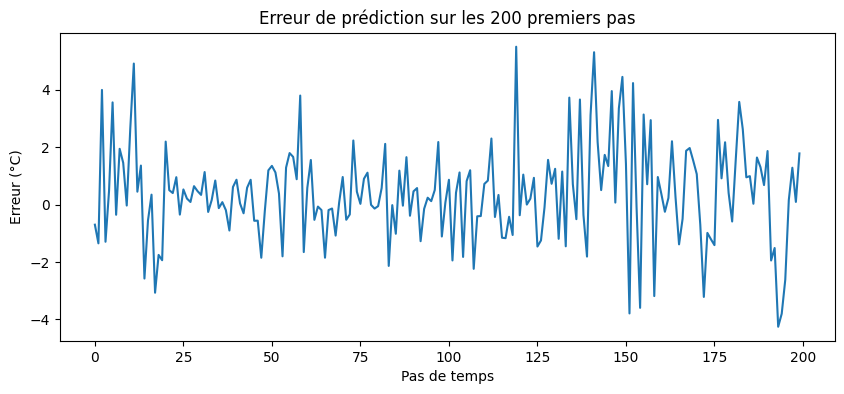

In [96]:
preds_inv, reals_inv, metrics = evaluate_model(
    model=model,
    test_loader=test_loader,
    scaler_y=scaler_y,
    device=device
)

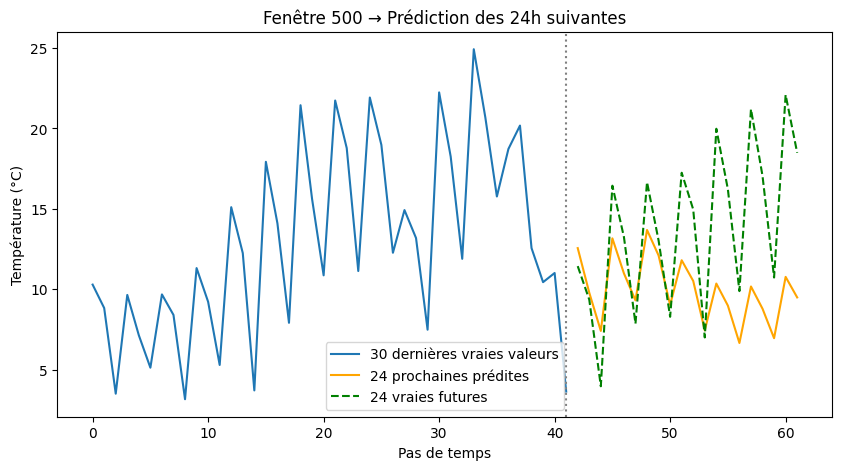

In [99]:
predict_and_plot(
    i=500 ,
    model=model,
    X_seq=X_test_seq,
    y_seq=y_test_seq,
    scaler_y=scaler_y,
    steps=20,
    device=device
)

### On a un gain de +0.05 sur la R2 de la variation de la température

# Essayant un modèle Boosting

In [253]:
df['temp_diff'] = df['Temperature (C)'].diff()


In [ ]:
window = 24  # taille de la fenêtre (24 heures)
X = []
y = []

for i in range(window, len(df) - 1):
    # On prend les 24 dernières variations et températures comme features
    past_diffs = df['temp_diff'].iloc[i-window:i].values
    past_temps = df['Temperature (C)'].iloc[i-window:i].values

    features = np.concatenate([past_diffs, past_temps])

    X.append(features)

    # Target = variation future (ΔTₙ₊₁)
    y.append(df['temp_diff'].iloc[i+1])

X = np.array(X)
y = np.array(y)


In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12055 entries, 0 to 12054
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      12055 non-null  datetime64[ns]
 1   period                    12055 non-null  object        
 2   Temperature (C)           12055 non-null  float64       
 3   Humidity                  12055 non-null  float64       
 4   Wind Speed (km/h)         12055 non-null  float64       
 5   Pressure (millibars)      12055 non-null  float64       
 6   Apparent Temperature (C)  12055 non-null  float64       
 7   Wind Bearing (degrees)    12055 non-null  float64       
 8   Visibility (km)           12055 non-null  float64       
 9   year                      12055 non-null  int32         
 10  day_sin                   12055 non-null  float64       
 11  day_cos                   12055 non-null  float64       
 12  month_sin         

In [254]:
import numpy as np
import pandas as pd

# Sélectionner les colonnes numériques sauf la target
features = [
    'Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Pressure (millibars)',
    'Apparent Temperature (C)', 'Wind Bearing (degrees)', 'Visibility (km)',
    'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'temp_diff'
]


On fait la concaténation des n dérnieres observations

In [228]:
window = 24
X = []
y = []

for i in range(window, len(df) - 1):
    # Fenêtre des 24 dernières heures (t-window → t-1)
    past_data = df[features].iloc[i-window:i].values.flatten()
    X.append(past_data)

    # Target à deux dimensions : [Température future, ΔT future]
    target_temp = df['Temperature (C)'].iloc[i+1]
    target_diff = df['temp_diff'].iloc[i+1]
    y.append([target_temp, target_diff])

X = np.array(X)
y = np.array(y)

print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (12030, 336), y shape: (12030, 2)


In [229]:
gap = 1
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index-gap], X[split_index:]
y_train, y_test = y[:split_index-gap], y[split_index:]


In [230]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

params = dict(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

multi_xgb = MultiOutputRegressor(XGBRegressor(**params))
multi_xgb.fit(X_train, y_train)

# Prédictions
y_pred = multi_xgb.predict(X_test)
print(y_pred.shape)  # → (n_test, 2)


(2406, 2)


In [231]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Température
mse_temp = mean_squared_error(y_test[:, 0], y_pred[:, 0])
r2_temp = r2_score(y_test[:, 0], y_pred[:, 0])

# Variation ΔT
mse_diff = mean_squared_error(y_test[:, 1], y_pred[:, 1])
r2_diff = r2_score(y_test[:, 1], y_pred[:, 1])

print(f"Température : MSE={mse_temp:.4f}, R²={r2_temp:.4f}")
print(f"Variation   : MSE={mse_diff:.4f}, R²={r2_diff:.4f}")


Température : MSE=4.8816, R²=0.9424
Variation   : MSE=5.0195, R²=0.8116


On trouve que le XGBoost dépasse largement les LSTM que ca soit dans le R2 de T et du R2 de delta T

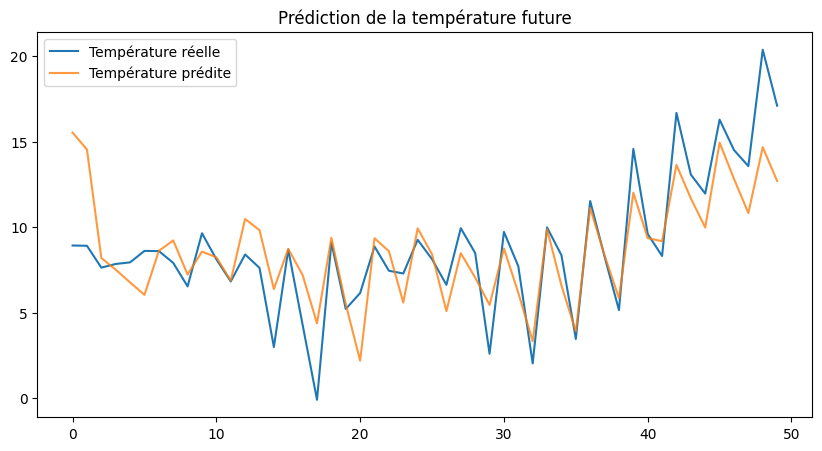

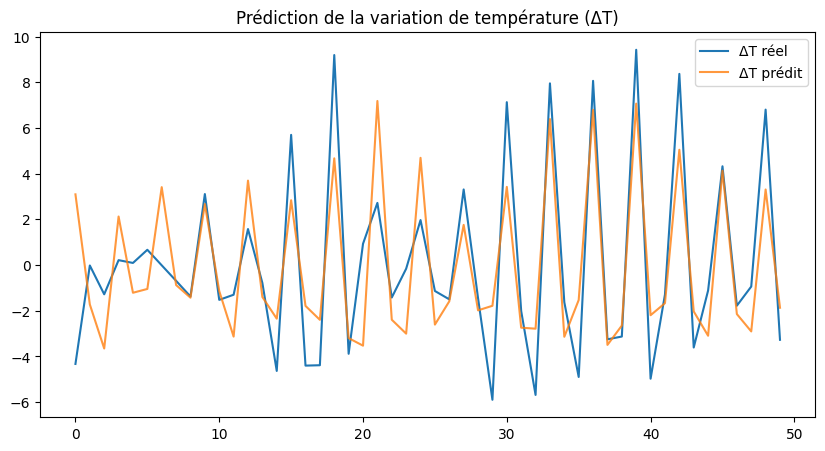

In [234]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test[:50, 0], label="Température réelle")
plt.plot(y_pred[:50, 0], label="Température prédite", alpha=0.8)
plt.legend()
plt.title("Prédiction de la température future")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(y_test[:50, 1], label="ΔT réel")
plt.plot(y_pred[:50, 1], label="ΔT prédit", alpha=0.8)
plt.legend()
plt.title("Prédiction de la variation de température (ΔT)")
plt.show()


In [235]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

params = dict(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42
)

multi_xgb = MultiOutputRegressor(XGBRegressor(**params))
multi_xgb.fit(X_train, y_train)

# Prédictions
y_pred = multi_xgb.predict(X_test)
print(y_pred.shape)

(2406, 2)


In [236]:
mse_temp = mean_squared_error(y_test[:, 0], y_pred[:, 0])
r2_temp = r2_score(y_test[:, 0], y_pred[:, 0])

mse_diff = mean_squared_error(y_test[:, 1], y_pred[:, 1])
r2_diff = r2_score(y_test[:, 1], y_pred[:, 1])

print(f"Température : MSE={mse_temp:.4f}, R²={r2_temp:.4f}")
print(f"Variation   : MSE={mse_diff:.4f}, R²={r2_diff:.4f}")

Température : MSE=4.9714, R²=0.9413
Variation   : MSE=4.8030, R²=0.8197


In [237]:
window = 24*2
X = []
y = []

for i in range(window, len(df) - 1):
    # Fenêtre des 24 dernières heures (t-window → t-1)
    past_data = df[features].iloc[i-window:i].values.flatten()
    X.append(past_data)

    # Target à deux dimensions : [Température future, ΔT future]
    target_temp = df['Temperature (C)'].iloc[i+1]
    target_diff = df['temp_diff'].iloc[i+1]
    y.append([target_temp, target_diff])

X = np.array(X)
y = np.array(y)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (12006, 672), y shape: (12006, 2)


In [238]:
gap = 1
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index-gap], X[split_index:]
y_train, y_test = y[:split_index-gap], y[split_index:]

In [239]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

params = dict(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

multi_xgb = MultiOutputRegressor(XGBRegressor(**params))
multi_xgb.fit(X_train, y_train)

# Prédictions
y_pred = multi_xgb.predict(X_test)
print(y_pred.shape)

(2402, 2)


In [241]:

mse_temp = mean_squared_error(y_test[:, 0], y_pred[:, 0])
r2_temp = r2_score(y_test[:, 0], y_pred[:, 0])

mse_diff = mean_squared_error(y_test[:, 1], y_pred[:, 1])
r2_diff = r2_score(y_test[:, 1], y_pred[:, 1])

print(f"Température : MSE={mse_temp:.4f}, R²={r2_temp:.4f}")
print(f"Variation   : MSE={mse_diff:.4f}, R²={r2_diff:.4f}")


Température : MSE=4.7987, R²=0.9434
Variation   : MSE=4.9037, R²=0.8162


#Conclusion : XGBoost dépasse les LSTM sur les séries temporelles si on a un petit jeu de donnée